# Testing production and degradation on ABC

In [1]:
import pints
import pints.toy as toy
import pints.toy.stochastic
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

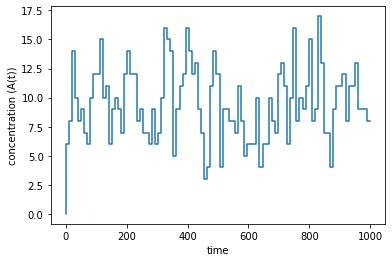

In [2]:
np.random.seed(7)

# Load a forward model
n_0 = 0
model = toy.stochastic.ProductionDegradationModel(n_0)

# Create some toy data
k = [0.1, 1]
times = np.linspace(0, 1000, 100)

values = model.simulate(k, times)
# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)
# Create a uniform prior parameter
log_prior = pints.UniformLogPrior([0.0, 0.3], [0.5, 1.7])
# Set the error measure to be used to compare simulated to observed data
error_measure = pints.RootMeanSquaredError(problem)
plt.step(times, values)


plt.xlabel('time')
plt.ylabel('concentration (A(t))')
plt.show()

# Calculating the posterior

In [3]:
import math

# Single stationary distribution
def s_stationary(theta, n):
    fct = math.factorial(n)
    frac = theta[1] / theta[0]
    return (frac ** n) * np.exp(-frac) / fct

def p_stationary(theta, data):
    prod = 1.0
    for d in data:
        prod *= s_stationary(theta, d[0])
    return prod

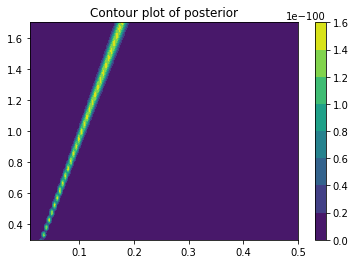

In [9]:
xlist = np.linspace(0.01, 0.5, 100)
ylist = np.linspace(0.3, 1.7, 100)
X, Y = np.meshgrid(xlist, ylist)
Z = [[p_stationary([x, y], values[10:]) for x in xlist] for y in ylist]
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp)
ax.set_title('Contour plot of posterior')
plt.show()

# Compute integral

In [10]:
from scipy import integrate

def f(x, y):
    return p_stationary([x, y], values[10:])

def bounds_x(y):
    return [0.0, 0.5]

def bounds_y():
    return [0.3, 1.7]

res = integrate.nquad(f, [bounds_x, bounds_y])

print("integral is ="+str(res))

def normalized_posterior(x, y):
    if 0 <= x and x <= 0.5 and 0.3 <= y and y <= 1.7:
        return p_stationary([x, y], values[10:]) / res[0]
    else:
        return 0

new_approx = integrate.nquad(normalized_posterior, [bounds_x, bounds_y])

print("new integral should be 1="+str(new_approx))


integral is =(1.8211254397553877e-102, 5.1387860661369676e-102)
new integral should be 1=(1.0203293773974849, 1.4105436687747898e-08)


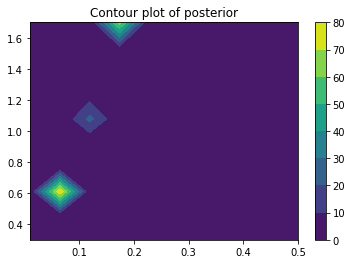

In [11]:
xlist = np.linspace(0.01, 0.5, 10)
ylist = np.linspace(0.3, 1.7, 10)
X, Y = np.meshgrid(xlist, ylist)
Z = [[normalized_posterior(x, y) for x in xlist] for y in ylist]
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp)
ax.set_title('Contour plot of posterior')
plt.show()

# Compute marginal distributions

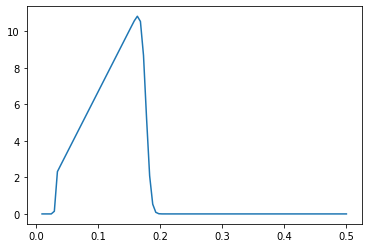

1 = 1.020329377397486


In [19]:
def marginal_distribution_x(x):
    partial_lam = lambda y : normalized_posterior(x, y)
    return integrate.quad(partial_lam, 0.3, 1.7)[0]

thetas = np.linspace(0.01, 0.5, 100)

results = []
for theta in thetas:
    results.append(marginal_distribution_x(theta))

plt.plot(thetas, results)
plt.show()


res_int_x = integrate.quad(marginal_distribution_x, 0, 0.5)[0]
print("1 = "+str(res_int_x))

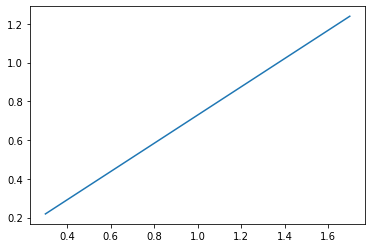

1 = 1.0203293773974849


In [17]:
def marginal_distribution_y(y):
    partial_lam = lambda x : normalized_posterior(x, y)
    return integrate.quad(partial_lam, 0, 0.5)[0]

thetas = np.linspace(0.3, 1.7, 100)

results = []
for theta in thetas:
    results.append(marginal_distribution_y(theta))

plt.plot(thetas, results)
plt.show()

res_int_y = integrate.quad(marginal_distribution_y, 0.3, 1.7)[0]
print("1 = "+str(res_int_y))

# Rejection ABC

In [9]:
abc = pints.ABCController(error_measure, log_prior)

# set threshold
abc.sampler().set_threshold(4.4)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using Rejection ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     4      0.25             0:00.2
2     5      0.4              0:00.2
3     9      0.333333333      0:00.3
20    376    0.0531914894     0:15.4
40    745    0.0536912752     0:27.8
60    1145   0.0524017467     0:40.8
80    1436   0.0557103064     0:50.9
100   1739   0.0575043128     1:00.8
120   2200   0.0545454545     1:16.3
140   2654   0.0527505652     1:32.2
160   3150   0.0507936508     1:48.5
180   3590   0.0501392758     2:03.2
200   3911   0.0511378164     2:14.3
220   4380   0.0502283105     2:32.2
240   4777   0.0502407369     2:45.4
260   5090   0.0510805501     2:56.0
280   5353   0.0523071175     3:05.6
300   5726   0.0523925952     3:21.0
320   6176   0.0518134715     3:36.8
340   6644   0.0511739916     3:52.6
360   7174   0.0501812099     4:10.5
380   7510   0.0505992011     4:22.7
400   8079   0.0495110781     4:42.6
420   8403   0.0499821492     4:53.6
440   8695   0.0

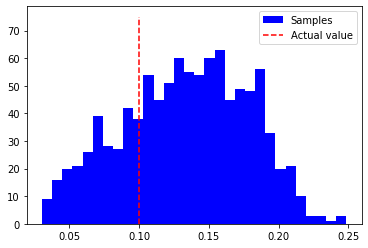

In [10]:
samples_flat = np.array([item for sublist in samples for item in sublist])

# print(samples_flat[:])
plt.hist(samples_flat[:,0], 30, color="blue", label="Samples")
plt.vlines(x=0.1, linestyles='dashed', ymin=0, ymax=75, label="Actual value", color="red")
plt.legend()
plt.show()

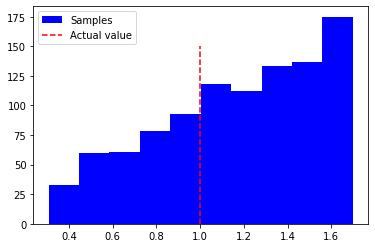

In [11]:
plt.hist(samples_flat[:,1], color="blue", label="Samples")
plt.vlines(x=1, linestyles='dashed', ymin=0, ymax=150, label="Actual value", color="red")
plt.legend()
plt.show()

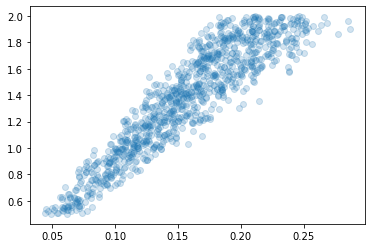

In [109]:
plt.scatter(samples_flat[:, 0], samples_flat[:, 1], alpha=0.2)
plt.show()

In [12]:
rej_samples = samples_flat

In [84]:
print(rej_samples.tolist())

[[0.15317284224672856, 1.3423125487782335], [0.06657758078303877, 0.6501009112942302], [0.07272037208652582, 0.6259694416419076], [0.07706675216111158, 0.6491880836944763], [0.14029354572876362, 1.4272477382354938], [0.05890745487366961, 0.5179503801710224], [0.16035348217727574, 1.3198768545377373], [0.149675487809033, 1.2641827915068382], [0.0823165464607869, 0.9182122631485361], [0.1802352143778128, 1.4645286131377917], [0.10152641895777043, 1.1165274982545699], [0.16320270535457332, 1.1987497645894103], [0.09091158096224539, 0.6481593217923465], [0.12134662956122905, 1.0831206435344245], [0.13735366551831346, 1.0703352965414579], [0.18957250644670443, 1.5286540139775726], [0.11876509618647962, 1.2656262890357437], [0.14434079653911236, 1.1628702284269359], [0.1434156774753626, 1.1176746997004907], [0.04716458764098136, 0.46905161814961766], [0.04766142597147727, 0.3939662015069478], [0.15104272405708924, 1.3959689143330047], [0.16693094608329617, 1.4540853767793969], [0.06719838446

# True PMC

In [20]:
np.random.seed(2)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
# set initial threshold
abc.sampler().set_threshold_schedule(np.array([9, 6, 4.4]))

# produce intermediate distributions of size 200
abc.sampler().set_intermediate_size(1000)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

samples = abc.run()
print("Done")

Using ABC-SMC
Running in sequential mode.
Trying t=1, threshold=6.0
Trying t=2, threshold=4.4
Iter. Eval. Acceptance rate Time m:s
1     4524   0.000221043324   2:56.3
2     4525   0.00044198895    2:56.3
3     4532   0.0006619594     2:56.7
20    4630   0.00431965443    3:00.7
40    4728   0.00846023689    3:04.6
60    4888   0.0122749591     3:10.8
80    5030   0.0159045726     3:16.4
100   5141   0.0194514686     3:20.5
120   5254   0.0228397411     3:24.7
140   5386   0.025993316      3:29.7
160   5514   0.0290170475     3:34.8
180   5649   0.0318640467     3:39.9
200   5759   0.0347282514     3:43.9
220   5865   0.0375106564     3:48.1
240   5975   0.040167364      3:52.3
260   6072   0.0428194993     3:56.1
280   6218   0.0450305564     4:02.1
300   6311   0.0475360482     4:05.8
320   6462   0.0495202724     4:11.5
340   6585   0.0516324981     4:16.4
360   6734   0.0534600535     4:22.2
380   6842   0.055539316      4:26.4
400   6949   0.0575622392     4:30.4
420   7112   0.059

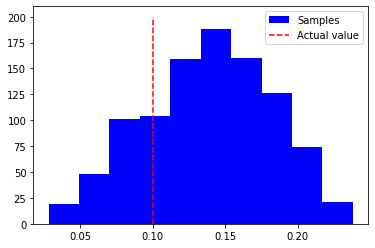

In [21]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=0.1, linestyles='dashed', ymin=0, ymax=200, label="Actual value", color="red")
# plt.plot(thetas, true_prob, label="posterior")
plt.legend()
plt.show()

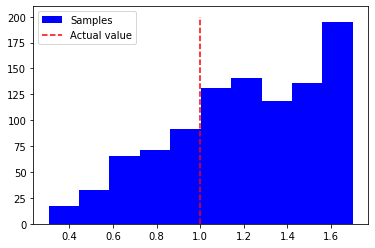

In [22]:
plt.hist(samples[:,1], color="blue", label="Samples")
plt.vlines(x=1, linestyles='dashed', ymin=0, ymax=200, label="Actual value", color="red")
# plt.plot(thetas, true_prob, label="posterior")
plt.legend()
plt.show()

In [23]:
res_pmc_true = samples

In [85]:
print(res_pmc_true.tolist())

[[0.09838005540756882, 0.9837714900298781], [0.11569271912276904, 0.8273246167867934], [0.11374629504205257, 0.8757220776249764], [0.12034855308185878, 1.0568325132413758], [0.12582989601418146, 0.961892336193515], [0.1794733317016941, 1.632278271602093], [0.1206507880017916, 1.1013149701997715], [0.16488718706180694, 1.5883685043205422], [0.0653292788895871, 0.5825338280753456], [0.1997837346779396, 1.5727877264144527], [0.11265611880496397, 0.882992411150225], [0.22891195570308442, 1.6364869391098837], [0.1826003364673489, 1.6472200718157055], [0.19332966676593383, 1.6086403116939834], [0.15579115459286702, 1.6365859631379633], [0.1365816667859006, 1.08187954695947], [0.15480970036378633, 1.3943648647025246], [0.13292272096836036, 1.2230619403785195], [0.11721277651651871, 1.039668463485526], [0.19324558835970376, 1.6612030237187607], [0.1968046569843785, 1.600544932524943], [0.054314458798523965, 0.55644050778011], [0.04748882561454924, 0.41730504071745766], [0.14234246481048596, 1.

# ABC SMC

In [14]:
np.random.seed(2)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
# set initial threshold
abc.sampler().set_threshold_schedule(np.array([9, 6, 4.4]))

# produce intermediate distributions of size 200
abc.sampler().set_intermediate_size(200)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

samples = abc.run()
print("Done")

Using ABC-SMC
Running in sequential mode.
Trying t=1, threshold=6.0
Trying t=2, threshold=4.4
Iter. Eval. Acceptance rate Time m:s
1     817    0.00122399021    0:27.5
2     821    0.00243605359    0:27.6
3     830    0.00361445783    0:27.9
20    919    0.0217627856     0:31.1
40    1020   0.0392156863     0:34.7
60    1117   0.0537153089     0:38.0
80    1206   0.0663349917     0:41.0
100   1319   0.0758150114     0:45.2
120   1411   0.0850460666     0:48.7
140   1508   0.0928381963     0:52.2
160   1612   0.0992555831     0:55.7
180   1763   0.102098695      1:01.3
200   1909   0.104766894      1:06.3
220   2042   0.107737512      1:11.2
240   2229   0.107671602      1:18.3
260   2379   0.109289617      1:23.7
280   2488   0.112540192926   1:27.4
300   2606   0.115118956      1:31.4
320   2753   0.116236833      1:36.9
340   2869   0.118508191      1:41.4
360   2954   0.121868653      1:44.5
380   3065   0.123980424      1:48.7
400   3181   0.125746621      1:52.9
420   3358   0.125

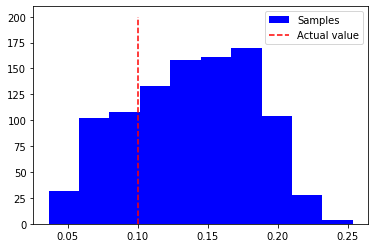

In [15]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=0.1, linestyles='dashed', ymin=0, ymax=200, label="Actual value", color="red")
# plt.plot(thetas, true_prob, label="posterior")
plt.legend()
plt.show()

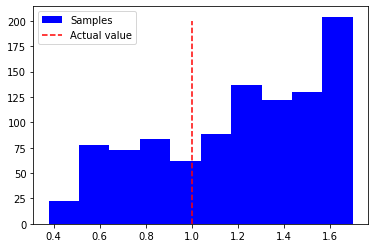

In [16]:
plt.hist(samples[:,1], color="blue", label="Samples")
plt.vlines(x=1, linestyles='dashed', ymin=0, ymax=200, label="Actual value", color="red")
# plt.plot(thetas, true_prob, label="posterior")
plt.legend()
plt.show()

In [19]:
res_pmc_fake = samples

[[0.160948   1.5438115 ]
 [0.08595913 0.71211951]
 [0.06219443 0.52379897]
 ...
 [0.15641889 1.65381068]
 [0.11079995 1.15542879]
 [0.10668317 0.826208  ]]


In [86]:
print(res_pmc_fake.tolist())

[[0.16094799589476436, 1.543811498730976], [0.08595912589939454, 0.7121195144519014], [0.062194428230645527, 0.5237989744075077], [0.13226140616017612, 1.1345972860675368], [0.07752458352138518, 0.8785060789867296], [0.180693895825659, 1.680190128022492], [0.15853470030156636, 1.5361498957057989], [0.054991012689544774, 0.4673000951336638], [0.0521961048934084, 0.41859562819192897], [0.11200743675362043, 0.8833697456281238], [0.19270644116202976, 1.636155666495334], [0.14028250468797532, 1.1196597801260368], [0.14252012055194263, 1.2929636737750605], [0.09182113827904312, 0.8510351158683325], [0.11195368426092589, 0.9965947307478867], [0.17833105959812948, 1.535218897808016], [0.16151799999275515, 1.3209595257091415], [0.19526404644867082, 1.6625219370704856], [0.100783660801974, 0.8709918293742693], [0.06684815367422897, 0.5883156608350812], [0.1458187338708484, 1.2962510221048877], [0.12868583902966402, 1.1957009014057587], [0.20606074044781045, 1.6757409336171936], [0.14022417071346

# Adaptive PMC ABC

In [26]:
np.random.seed(2)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCAdaptivePMC)

# set threshold
abc.sampler().set_N_l(900)

# set p_acc_min
abc.sampler().set_p_acc_min(0.05)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using ABC-Adaptive-PMC
Running in sequential mode.
w_mean=[0.26406768 0.97621798]
resulting var=[[0.03460114 0.00209416]
 [0.00209416 0.33470176]]
epsilon=8.835157044444655
w_mean=[0.27423849 1.0179161 ]
resulting var=[[0.0345846  0.03439441]
 [0.03439441 0.3083543 ]]
epsilon=8.402975663418287
w_mean=[0.26469616 1.05710261]
resulting var=[[0.03100384 0.03129408]
 [0.03129408 0.27805362]]
epsilon=8.039900496896712
w_mean=[0.25482128 1.0846015 ]
resulting var=[[0.03126627 0.04533777]
 [0.04533777 0.28713434]]
epsilon=7.765951326141569
w_mean=[0.24434051 1.12666726]
resulting var=[[0.02860071 0.04826479]
 [0.04826479 0.26711843]]
epsilon=7.5193084788429845
w_mean=[0.24194388 1.15158973]
resulting var=[[0.02767796 0.0502673 ]
 [0.0502673  0.27291046]]
epsilon=7.312318373812781
w_mean=[0.22634485 1.15591049]
resulting var=[[0.02549423 0.05087997]
 [0.05087997 0.28412418]]
epsilon=7.140728254176881
w_mean=[0.2191117  1.16548918]
resulting var=[[0.02371957 0.04954558]
 [0.04954558 

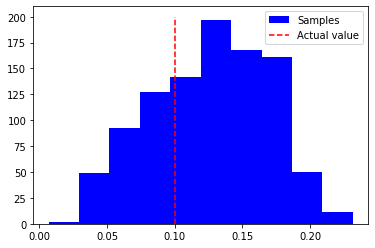

In [27]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=0.1, linestyles='dashed', ymin=0, ymax=200, label="Actual value", color="red")
plt.legend()
plt.show()

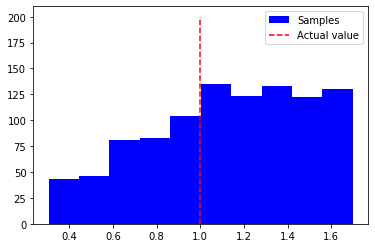

In [28]:
plt.hist(samples[:,1], color="blue", label="Samples")
plt.vlines(x=1, linestyles='dashed', ymin=0, ymax=200, label="Actual value", color="red")
plt.legend()
plt.show()

In [33]:
res_adaptive = np.array(samples)

In [35]:
print(res_adaptive.tolist())

[[0.08534276301701305, 0.7829719435480677], [0.12249706920708486, 1.0070866888079975], [0.14810247690626505, 1.4786146856287994], [0.07399457602979864, 0.693642847498172], [0.13705874410217267, 1.4238811617808698], [0.09705498050939254, 0.9007453897251363], [0.15466780467111996, 1.242850884404623], [0.1306398433124371, 1.218014949670333], [0.1286793463617989, 1.114065257990986], [0.11698558468969605, 1.058754056887573], [0.17596451844681488, 1.4730025048045559], [0.1549889913671384, 1.3807839987524118], [0.16458490017034538, 1.3064449078651554], [0.1029214784828561, 0.7915127213131955], [0.1468913971516413, 1.1872594165311183], [0.13321883803053935, 1.0288950635367538], [0.17814754752587675, 1.5916384196825168], [0.12029389770466578, 1.079398773217215], [0.12760438546728484, 1.2344582452689745], [0.15397376911239657, 1.3349481472701035], [0.17380134666270308, 1.494441649197404], [0.18037438427425564, 1.622025548794043], [0.06541345116953057, 0.48465163420165785], [0.12137330238406215, 

# SGLD Hamiltonian

In [9]:
from scipy.stats import multivariate_normal

class ActuallySyntheticLikelihood:
    def __init__(self, y, eps):
        y = np.array(y)
        if len(y.shape) == 1:
            self._y = np.array([y])
        else:
            self._y = np.array(y)
        self._eps = eps
        if isinstance(self._eps, (list, tuple, np.ndarray)):
            self._eps = np.diag(np.square(self._eps))

    def pdf(self, vals):   
        # estimate mean
        t_mean = np.zeros((len(self._y), len(self._y[0])))
        
        # vals[i] = the i-th datapoint
        # vals[i][j] = the population at time t[j]
        for j in range(len(self._y)):
            for i in range(len(vals)):
                t_mean[j] += vals[i][j]
            t_mean[j] /= (len(vals))
        
        t_cov = np.zeros( (len(self._y), len(self._y[0]), len(self._y[0])) )
        

        # t_cov[i] = covariance matrix for time i
        for i in range(len(self._y)):
            for j in range(len(vals)):
                one_t = np.array([vals[j][i] - t_mean[i]])
                t_cov[i] += one_t * np.transpose(one_t)
            
            t_cov[i] /= (len(vals) - 1)
            t_cov[i] += self._eps
            
#         print("t_cov=")
#         print(t_cov)
        rez = 0
        
        for i in range(len(self._y)):
            rez += (multivariate_normal.pdf(self._y[i], mean=t_mean[i], cov=t_cov[i]))


        rez = np.log(rez)
        return rez

In [47]:
class HABCsgld:
    def __init__(self, T, theta0, m, eps, s_eps, log_prior, sim_f, c, y):
        self._T = T
        self._theta0 = theta0
        self._dim = len(theta0)
        self._m = m
        self._eps = eps
        self._c = c
        self._cnt = 0
        self._mean = np.zeros(self._dim)
        
        # Functions
        self._log_prior = log_prior
        self._grad_prior = self.grad_pr 
        self._sim_f = sim_f
        self._cnt_samples = 0
        
        # Build synthetic likelihood
        self._synt_l = ActuallySyntheticLikelihood(y, s_eps)
        
        self._grads = []
    
    def grad_pr(self, theta):
        x, dx = self._log_prior.evaluateS1(theta)
        return dx
    
    def spsa(self, theta, d_theta, S, R):
        self._grads = None
        if (len(theta.shape) > 1):
            dim = len(theta[0])
        else:
            dim = len(theta)
        g = np.zeros(dim)
        
        for r in range(R):
            # Generate bernoulli distribution vector
            delta = np.zeros(dim)
            for i in range(dim):
                delta[i] = (2 * np.random.binomial(n=1, p=0.5) - 1)
            
            
            set_plus = None
            set_minus = None
            
            aux = 0
            
            for s in range(S):
                x_plus = self._sim_f(theta + d_theta * delta)
                x_minus = self._sim_f(theta - d_theta * delta)
                self._cnt_samples += 2
                
                if len(x_plus.shape) == 1:
                    x_plus = [[x] for x in x_plus]
                if len(x_minus.shape) == 1:
                    x_minus = [[x] for x in x_minus]
                    
                if set_plus is None:
                    set_plus = [x_plus]
                    set_minus = [x_minus]
                else:
                    set_plus.append(x_plus)
                    set_minus.append(x_minus)
                
            term = (self._synt_l.pdf(set_plus) - self._synt_l.pdf(set_minus)) * delta
            g += term

        g = ( 1 / (2 * d_theta * R) ) * g
        
        grad_val = self.grad_pr(theta)
        # if len(grad_val.shape) > 1:
            # grad_val = grad_val[0]
        g += np.exp(grad_val)
        
        return -g
        
    def run(self):
        # Initialize stuff
        self._results = [self._theta0]
        
        for t in range(1, self._T):
            done = False
            
            while not done:
                # Resample momentum
                
                curr_theta = self._results[t-1]
                curr_momentum = np.random.multivariate_normal(np.zeros(self._dim), np.eye(self._dim))
                
                i = 0
                problem = False
                
                while not problem and i <= self._m:
                    spsa_term = self.spsa(curr_theta, 0.0001, S=2, R=1)
                    next_theta = curr_theta + self._eps * np.random.normal(0, np.eye(self._dim)) - \
                                 (self._eps ** 2) / 2 * spsa_term
                    if self._log_prior(next_theta + 0.0001 * np.ones(self._dim)) == np.NINF \
                        or self._log_prior(next_theta - 0.0001 * np.ones(self._dim)) == np.NINF:
                        problem = True
                    else:
                        
    #                     print("spsa_term=" + str(spsa_term * self._eps))
    #                     print("second term=" + str(self._eps * self._C * curr_momentum))
    #                     print("third term=" + str(np.random.multivariate_normal(np.zeros(self._dim), 2 * self._eps * (self._C - self._B))))
    #                     print("next_theta="+str(next_theta))
    #                     print("next_momentum="+str(next_momentum))
                        curr_theta = next_theta
                        if self._log_prior(curr_theta) == np.NINF:
                            problem = True
                        i = i + 1
                if not problem:
                    done = True
                    self._results.append(curr_theta)
            print("t= " + str(t) + ", " + "curr_theta =" + str(curr_theta))
        
        print("count samples = "+str(self._cnt_samples))
        return self._results

In [54]:
np.random.seed(1)

y = np.array([[x] for x in values])

theta0 = np.array([0.15, 0.8])

def grad_prior(theta):
    x, dx = log_prior.evaluateS1(theta)
    return dx

# Simulating function
def sim_f(theta):
#     print("trying " + str(theta))
    if len(theta.shape) == 2:
        theta = theta[0]
#     print("in the end we have " + str(theta))
    return model.simulate(theta, times)


abc = HABCsgld(1000, theta0, 5, 0.007, 0.1, log_prior, sim_f, 0.001, y)

print("abc started")        

results = abc.run()

print("abc finished")
print(results)

abc started
t= 1, curr_theta =[[0.02068325 0.83014348]
 [0.03764695 0.84869473]]
t= 2, curr_theta =[[0.15160365 0.76457291]
 [0.16287283 0.80276243]]
t= 3, curr_theta =[[0.14464922 0.72093286]
 [0.16045251 0.74977527]]
t= 4, curr_theta =[[0.138065   0.57193605]
 [0.1556758  0.59140707]]
t= 5, curr_theta =[[0.20855957 0.67381491]
 [0.21907131 0.67742247]]
t= 6, curr_theta =[[0.26823413 0.72656984]
 [0.26898255 0.74627888]]
t= 7, curr_theta =[[0.34526334 0.77085724]
 [0.33345968 0.76416243]]
t= 8, curr_theta =[[0.37573263 0.77110614]
 [0.35860367 0.75990509]]
t= 9, curr_theta =[[0.35677801 0.77254442]
 [0.33770148 0.75766159]]
t= 10, curr_theta =[[0.37221382 0.77333067]
 [0.34106082 0.75500173]]
t= 11, curr_theta =[[0.40571913 0.75249499]
 [0.36228497 0.75705348]]
t= 12, curr_theta =[[0.46915238 0.69573701]
 [0.41933696 0.69323779]]
t= 13, curr_theta =[[0.37909709 0.68883835]
 [0.34588736 0.66674375]]
t= 14, curr_theta =[[0.35610915 0.76911427]
 [0.30893789 0.73823601]]
t= 15, curr_theta

In [55]:
res_f = np.array([x for z in results[2:] for x in z])

# rest_res = res_f[2:]
# print(rest_res)

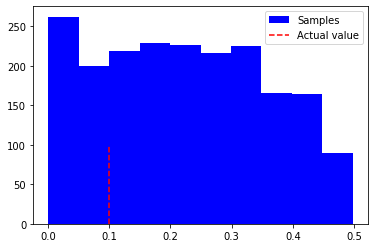

In [56]:

plt.hist(res_f[:, 0], color="blue", label="Samples")
plt.vlines(x=0.1, linestyles='dashed', ymin=0, ymax=100, label="Actual value", color="red")
plt.legend()
plt.show()

# plt.hist(rest_res[:,0], color="blue", label="Samples")
# plt.vlines(x=0.1, linestyles='dashed', ymin=0, ymax=200, label="Actual value", color="red")
# plt.legend()
# plt.show()

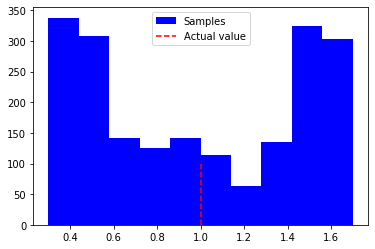

In [57]:
plt.hist(res_f[:, 1], color="blue", label="Samples")
plt.vlines(x=1, linestyles='dashed', ymin=0, ymax=100, label="Actual value", color="red")
plt.legend()
plt.show()

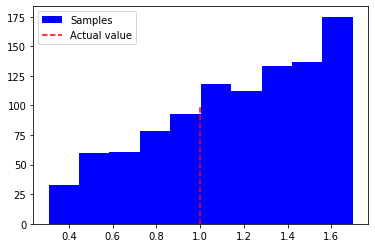

In [102]:
plt.hist(np.array(samples_rej_abc)[:, 1], color="blue", label="Samples")
plt.vlines(x=1, linestyles='dashed', ymin=0, ymax=100, label="Actual value", color="red")
plt.legend()
plt.show()

# Visualizations

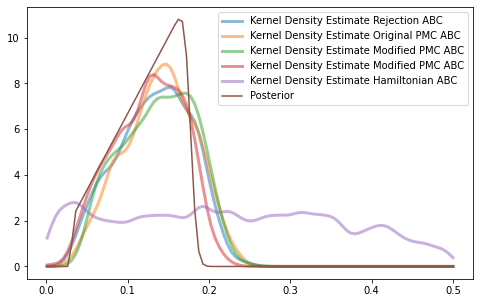

In [44]:
def marginal_distribution_x(x):
    partial_lam = lambda y : normalized_posterior(x, y)
    return integrate.quad(partial_lam, 0.3, 1.7)[0]


def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(0.001, 0.5, 100)

vals = []
for x in x_grid:
    vals.append(marginal_distribution_x(x))

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8, 5))
ax.plot(x_grid, kde_sklearn(np.array(samples_rej_abc)[:, 0], x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_true)[:, 0], x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Original PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_fake)[:, 0], x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Modified PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_adaptive_pmc)[:, 0], x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Modified PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(res_f)[:, 0], x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Hamiltonian ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, vals, label='Posterior')
ax.legend()

import os
__file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\production_degradation"
my_path = os.path.abspath(__file)

plt.savefig(my_path + '/production_degradation_kde_x.pdf')

# plt.show()

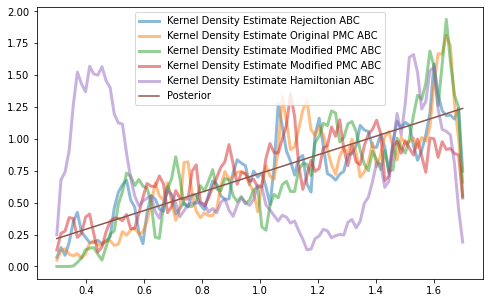

In [45]:
def marginal_distribution_y(y):
    partial_lam = lambda x : normalized_posterior(x, y)
    return integrate.quad(partial_lam, 0, 0.5)[0]

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(0.3, 1.7, 100)

vals = []
for x in x_grid:
    vals.append(marginal_distribution_y(x))

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8, 5))
ax.plot(x_grid, kde_sklearn(np.array(samples_rej_abc)[:, 1], x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_true)[:, 1], x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Original PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_fake)[:, 1], x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Modified PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_adaptive_pmc)[:, 1], x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Modified PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(res_f)[:, 1], x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Hamiltonian ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, vals, label='Posterior')
ax.legend()

import os
__file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\production_degradation"
my_path = os.path.abspath(__file)

plt.savefig(my_path + '/production_degradation_kde_y.pdf')

# plt.show()

In [31]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

def marginal_distribution_x(x):
    partial_lam = lambda y : normalized_posterior(x, y)
    return integrate.quad(partial_lam, 0.3, 1.7)[0]

def kl_func_x(y, kde_skl):
    part = marginal_distribution_x(y)
    s_part = np.exp(kde_skl.score_samples([[y]]))
    if s_part == 0 or part == 0:
        return -np.inf
    else:
        saved = part * np.log(part / s_part)
        return saved

def kl_div_x(x, bandwidth, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    fun = lambda y : kl_func_x(y, kde_skl)
    return integrate.quad(fun, 0.025, 0.5)

# computing the KDE and KL functions for x
def marginal_distribution_y(y):
    partial_lam = lambda x : normalized_posterior(x, y)
    return integrate.quad(partial_lam, 0, 0.5)[0]

def kl_func_y(y, kde_skl):
    part = marginal_distribution_y(y)
    s_part = np.exp(kde_skl.score_samples([[y]]))
    if s_part == 0 or part == 0:
        return -np.inf
    else:
        saved = part * np.log(part / s_part)
        return saved

def kl_div_y(x, bandwidth, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    fun = lambda y : kl_func_y(y, kde_skl)
    return integrate.quad(fun, 0.3, 1.7)

# print(marginal_distribution_y(0.3))
saved_x = kl_div_x(np.array(res_f)[:, 0], 0.01)[0]
saved_y = kl_div_y(np.array(res_f)[:, 1], 0.1)[0]
saved_ham = saved_x + saved_y 
saved_rej = kl_div_x(np.array(samples_rej_abc)[:, 0], 0.01)[0] + kl_div_y(np.array(samples_rej_abc)[:, 1], 0.1)[0]
saved_pmc_fake = kl_div_x(np.array(samples_pmc_fake)[:, 0], 0.01)[0] + kl_div_y(np.array(samples_pmc_fake)[:, 1], 0.1)[0]
saved_pmc_true = kl_div_x(np.array(samples_pmc_true)[:, 0], 0.01)[0] + kl_div_y(np.array(samples_pmc_true)[:, 1], 0.1)[0]
saved_adaptive = kl_div_x(np.array(samples_adaptive_pmc)[:, 0], 0.01)[0] + kl_div_y(np.array(samples_adaptive_pmc)[:, 1], 0.1)[0]


print("rejection kl = " + str(saved_rej))
print("modified pmc kl = " + str(saved_pmc_fake))
print("original pmc kl = " + str(saved_pmc_true))
print("adaptive pmc kl = " + str(saved_adaptive))
# both can be negative values????? 
print("hamiltonian kl = " + str(saved_ham))
print("s_x = "+str(saved_x) + ", s_y = "+str(saved_y))

rejection kl = 0.2758352353338104
modified pmc kl = 0.33573376920861364
original pmc kl = 0.32348219117021415
adaptive pmc kl = 0.21674479268433666
hamiltonian kl = 1.5066926479372902
s_x = 1.2152158296904976, s_y = 0.29147681824679267


In [135]:
print(res_f.tolist())

[[0.1516036496651253, 0.7645729060784477], [0.16287282504087433, 0.8027624328704848], [0.1446492225093211, 0.7209328642990187], [0.16045250663021676, 0.7497752713471988], [0.13806499559425853, 0.5719360467896721], [0.15567580343904447, 0.591407073324153], [0.20855957268748304, 0.6738149131242152], [0.2190713083453965, 0.6774224702862367], [0.2682341302971282, 0.7265698353956861], [0.2689825489328102, 0.7462788834019023], [0.34526333686394367, 0.7708572355875063], [0.33345968097645373, 0.7641624266909856], [0.37573263409611307, 0.7711061380631916], [0.35860366848130676, 0.7599050863159807], [0.35677800722325276, 0.7725444177605104], [0.3377014797460028, 0.7576615880448664], [0.3722138199023544, 0.7733306655155547], [0.3410608178157644, 0.7550017260624999], [0.40571912521025744, 0.7524949923798442], [0.3622849739516959, 0.7570534824876926], [0.4691523750891607, 0.6957370111039698], [0.41933695522757025, 0.6932377866076386], [0.37909708567136174, 0.6888383450906885], [0.3458873571731913, 